## **1. Import Library**

Mengimport library-library yang dibutuhkan untuk membuat model

In [1]:
import numpy as np # aljabar linear dan manipulasi angka
import matplotlib.pyplot as plt # visualisasi
import pandas as pd # manipulasi data
import seaborn as sns # visualisasi

from sklearn.preprocessing import OneHotEncoder, StandardScaler # encoding fitur kategori dan standarisasi fitur numerik
from sklearn.model_selection import train_test_split # membagi dataset ke train dan test
from sklearn.ensemble import RandomForestClassifier # algoritma randomforest
from xgboost import XGBClassifier # algoritma xgboost
from lightgbm import LGBMClassifier # algoritma lightgbm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix # evaluasi model

## **2. Data Loading**

Load dataset dari path

In [2]:
path = "/mnt/d/Artificial Intellegence/Machine Learning/CodingCamp/Proyek Machine Learning Terapan/PredictiveAnalysis/diabetes_prediction_dataset.csv"
df = pd.read_csv(path)

Melihat sample dari data

In [3]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


## **3. Exploratory Data Analysis (EDA)**

### 3.1. Deskripsi Variabel

Malihat struktur dataset, dari hasil nampaknya tidak ada missing value.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


Analisis statistik deskriptif pada variabel numerik, ada indikasi outlier fitur blood_glucose_level, HbA1c_level dan bmi.

In [5]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


### 3.2. Menangani Missing Value dan Outlier

Mengecek dataset apakah terdapat missing values

In [6]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Mengecek total kategori pada fitur gender, ada kategori yang hanya ada 18 dari total keseluruhan data dan sangat timpang jumlah data keseluruhan.

In [7]:
print(df['gender'].value_counts())

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64


Mangganti kategori yang jumlahnya sekitar 0.001% dengan modus dari kategori lain.

In [8]:
gender_mode = df['gender'].mode()[0]  

df['gender'] = df['gender'].replace('Other', gender_mode)

Mengecek dan menangani Outlier

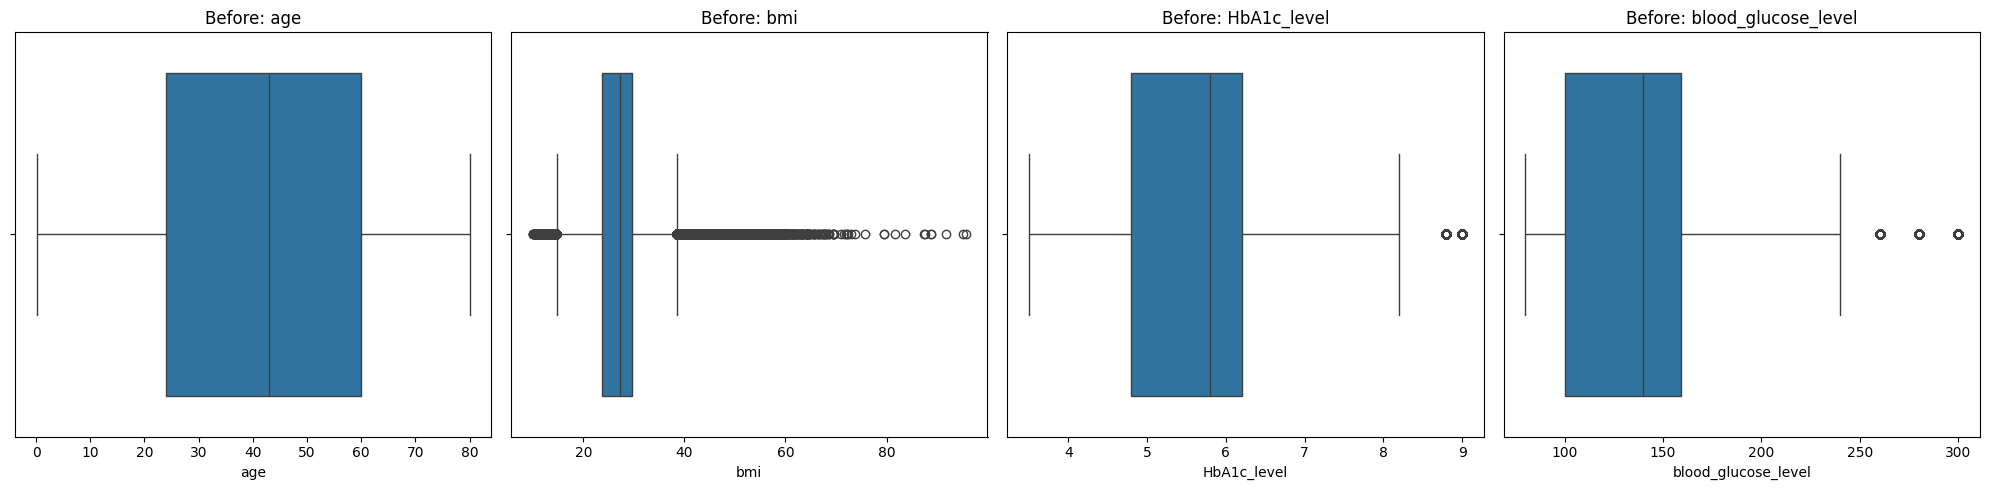


Jumlah Outlier per Kolom (Sebelum Clipping):
age: 0 outlier
bmi: 7086 outlier
HbA1c_level: 1315 outlier
blood_glucose_level: 2038 outlier


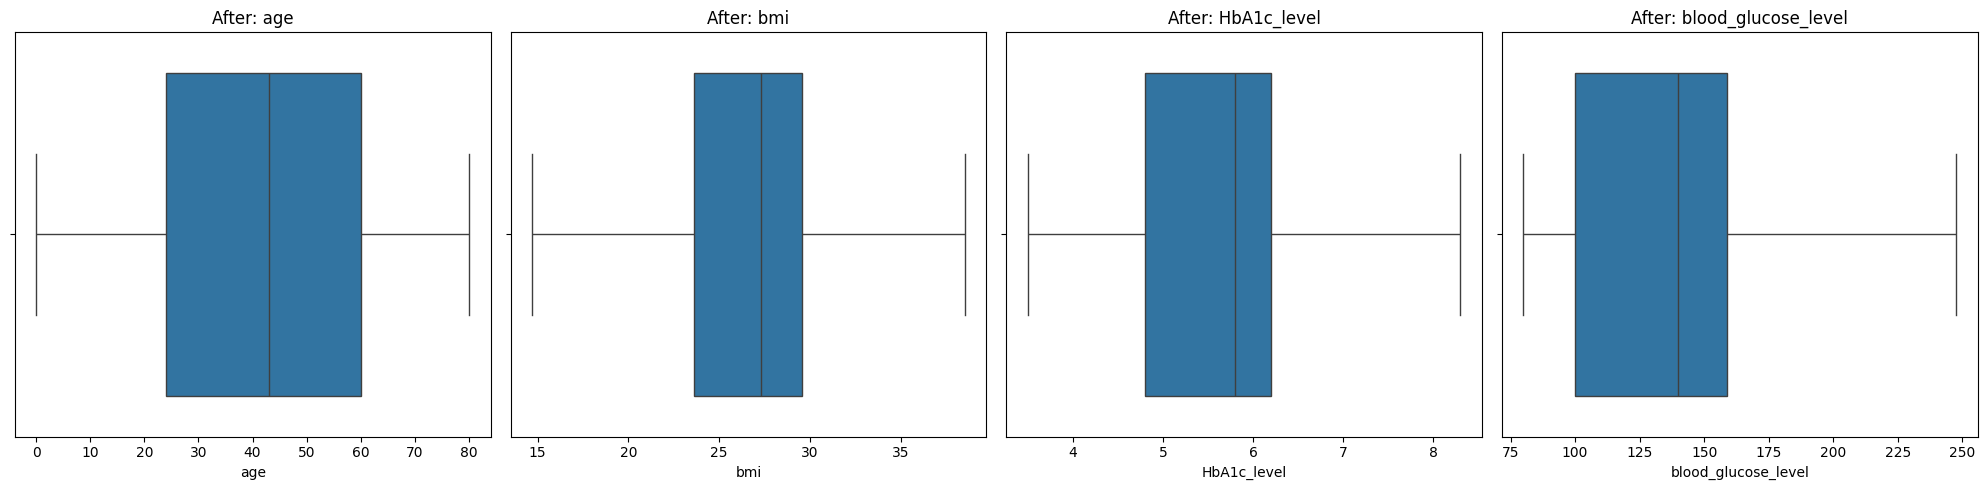

In [9]:
numerical_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

outlierValues = {}

fig, axes = plt.subplots(1, len(numerical_features), figsize=(5 * len(numerical_features), 5))

if len(numerical_features) == 1:
    axes = [axes]

for ax, col in zip(axes, numerical_features):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"Before: {col}")

plt.tight_layout()
plt.show()

for col in numerical_features:
    q25 = np.percentile(df[col].dropna(), 25)
    q75 = np.percentile(df[col].dropna(), 75)
    iqr = q75 - q25
    lowerBound = q25 - 1.5 * iqr
    upperBound = q75 + 1.5 * iqr

    outliers = df[col][(df[col] < lowerBound) | (df[col] > upperBound)]
    outlierValues[col] = outliers

    df[col] = np.clip(df[col], lowerBound, upperBound)

print("\nJumlah Outlier per Kolom (Sebelum Clipping):")
for col, outliers in outlierValues.items():
    print(f"{col}: {len(outliers)} outlier")

fig, axes = plt.subplots(1, len(numerical_features), figsize=(5 * len(numerical_features), 5))

if len(numerical_features) == 1:
    axes = [axes]

for ax, col in zip(axes, numerical_features):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f"After: {col}")

plt.tight_layout()
plt.show()

### 3.3. Univariate Analysis

Mengelompokan kolom ke numerik dan kategorikal.

In [10]:
numerical_features = ['age','bmi','HbA1c_level','blood_glucose_level']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']

Memvisualisasi untuk melihat distibusi nilai dari semua kolom numerik.

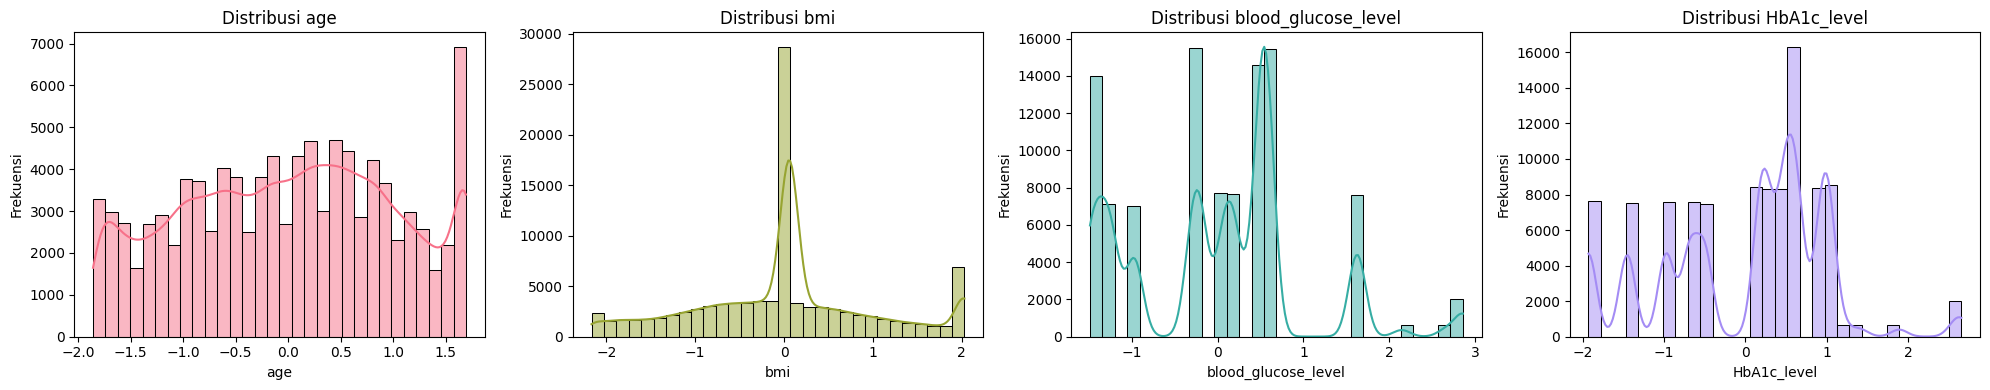

In [40]:
plt.figure(figsize=(5 * len(numerical_features), 4))  

for i, col in enumerate(numerical_features, 1):
    plt.subplot(1, len(numerical_features), i)  
    
    color = sns.color_palette("husl", len(numerical_features))[i-1]  
    
    if df[col].nunique() > 10:
        sns.histplot(df[col].dropna(), bins=30, kde=True, color=color)
    else:
        sns.countplot(x=df[col], palette="husl")

    plt.title(f"Distribusi {col}")
    plt.xlabel(col)
    plt.ylabel("Frekuensi")

plt.tight_layout()  # Menghindari tumpang tindih
plt.show()

Memvisualisasi untuk melihat distibusi persebaran nilai dari masing masing kategori dari semua kolom Kategori.


Distribusi Kategori untuk 'gender':
        Jumlah Sampel  Persentase
gender                           
Female          58570        58.6
Male            41430        41.4
--------------------------------------------------

Distribusi Kategori untuk 'hypertension':
              Jumlah Sampel  Persentase
hypertension                           
0                     92515        92.5
1                      7485         7.5
--------------------------------------------------

Distribusi Kategori untuk 'heart_disease':
               Jumlah Sampel  Persentase
heart_disease                           
0                      96058        96.1
1                       3942         3.9
--------------------------------------------------

Distribusi Kategori untuk 'smoking_history':
                 Jumlah Sampel  Persentase
smoking_history                           
No Info                  35816        35.8
never                    35095        35.1
former                    9352         9.4
cu

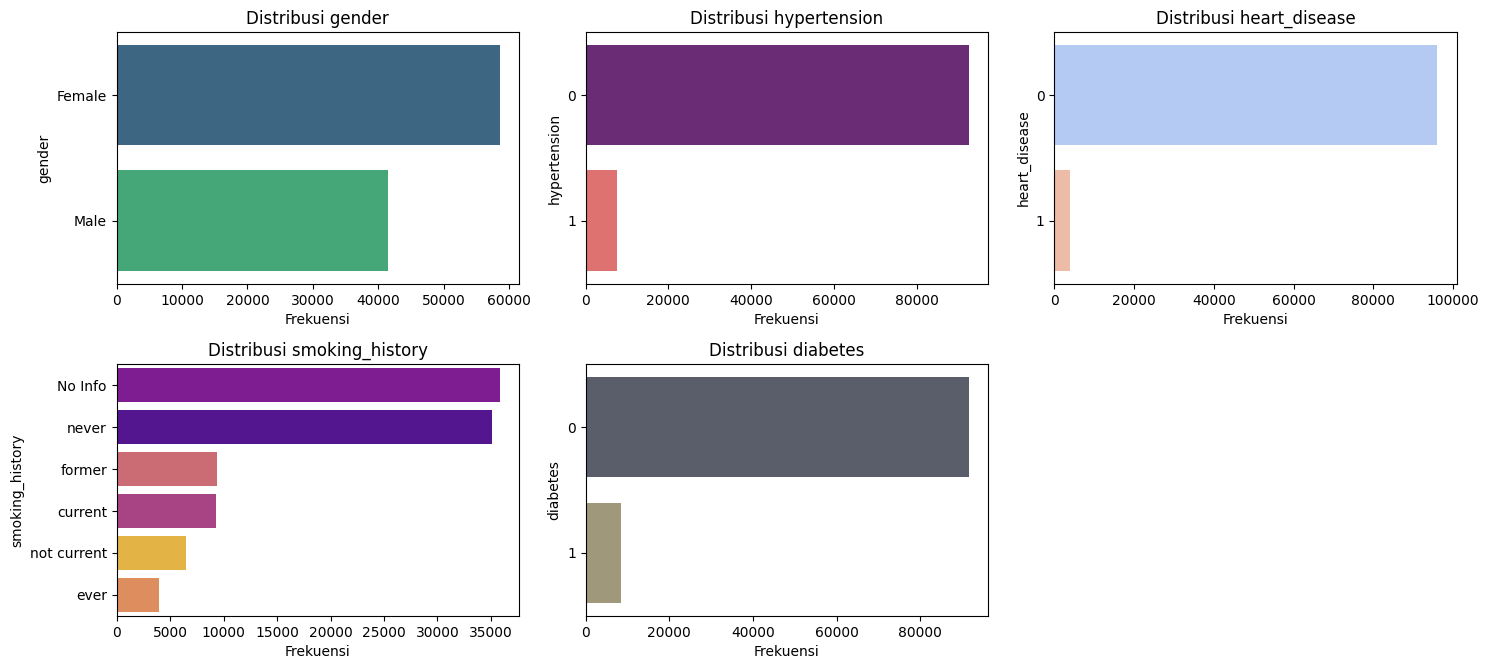

In [12]:
plt.figure(figsize=(15, 13))

palettes = [
    "viridis", "magma", "coolwarm", "plasma", "cividis", "inferno",
]

for col in categorical_features:
    count = df[col].value_counts()
    percent = 100 * df[col].value_counts(normalize=True)
    
    df_count = pd.DataFrame({'Jumlah Sampel': count, 'Persentase': percent.round(1)})
    
    print(f"\nDistribusi Kategori untuk '{col}':")
    print(df_count)
    print("-" * 50)

for i, (col, palette) in enumerate(zip(categorical_features, palettes), 1):
    plt.subplot(4, 3, i)
    sns.countplot(y=df[col], order=df[col].value_counts().index, hue=df[col], palette=palette, legend=False)
    plt.title(f"Distribusi {col}")
    plt.xlabel("Frekuensi")
    plt.ylabel(col)

plt.tight_layout()
plt.show()


### 3.4. Multivariate Analysis

Melihat rata rata diabetes vs fitur lain dalam dataset

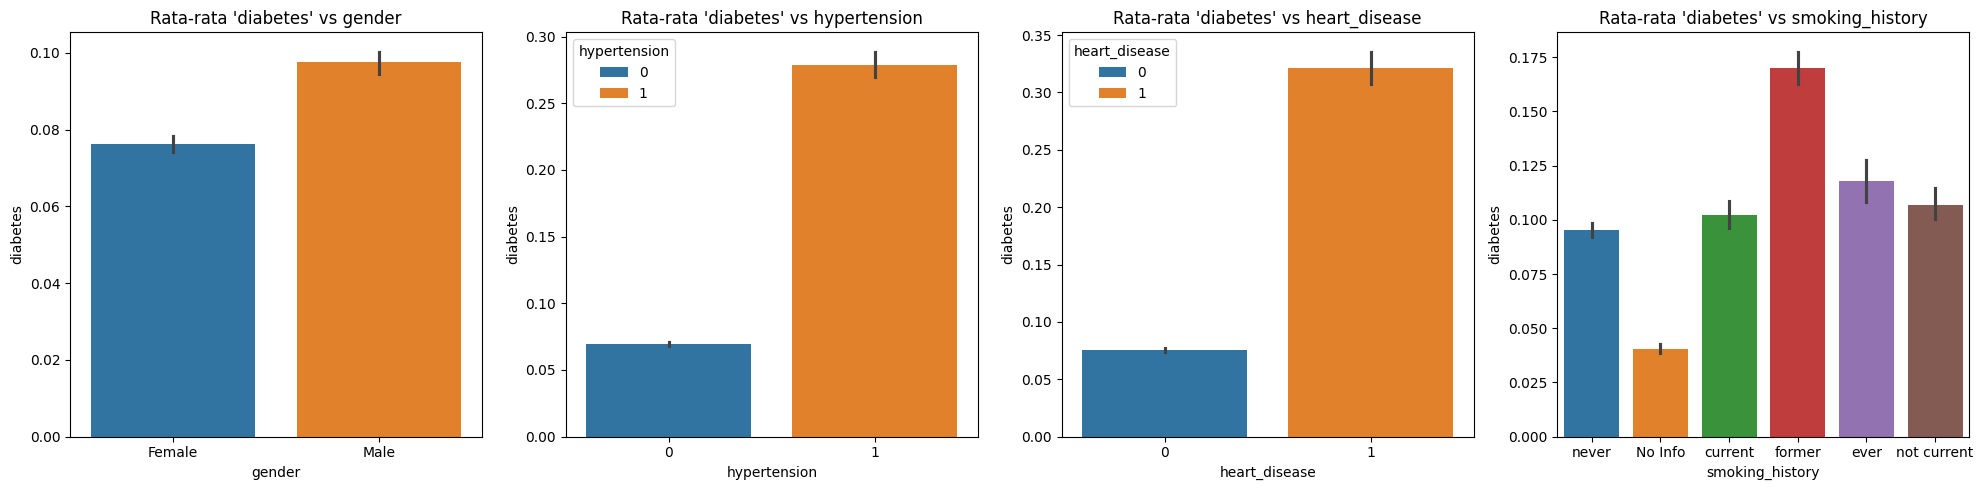

In [13]:
categorical_features = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

fig, axes = plt.subplots(1, len(categorical_features), figsize=(20, 5))

for i, col in enumerate(categorical_features):
    sns.barplot(x=col, y="diabetes", data=df, ax=axes[i], hue=col, estimator=lambda x: sum(x)/len(x))
    axes[i].set_title(f"Rata-rata 'diabetes' vs {col}")

plt.tight_layout()
plt.show()

Memvisualisasikan hubungan antar variabel dalam dataset.

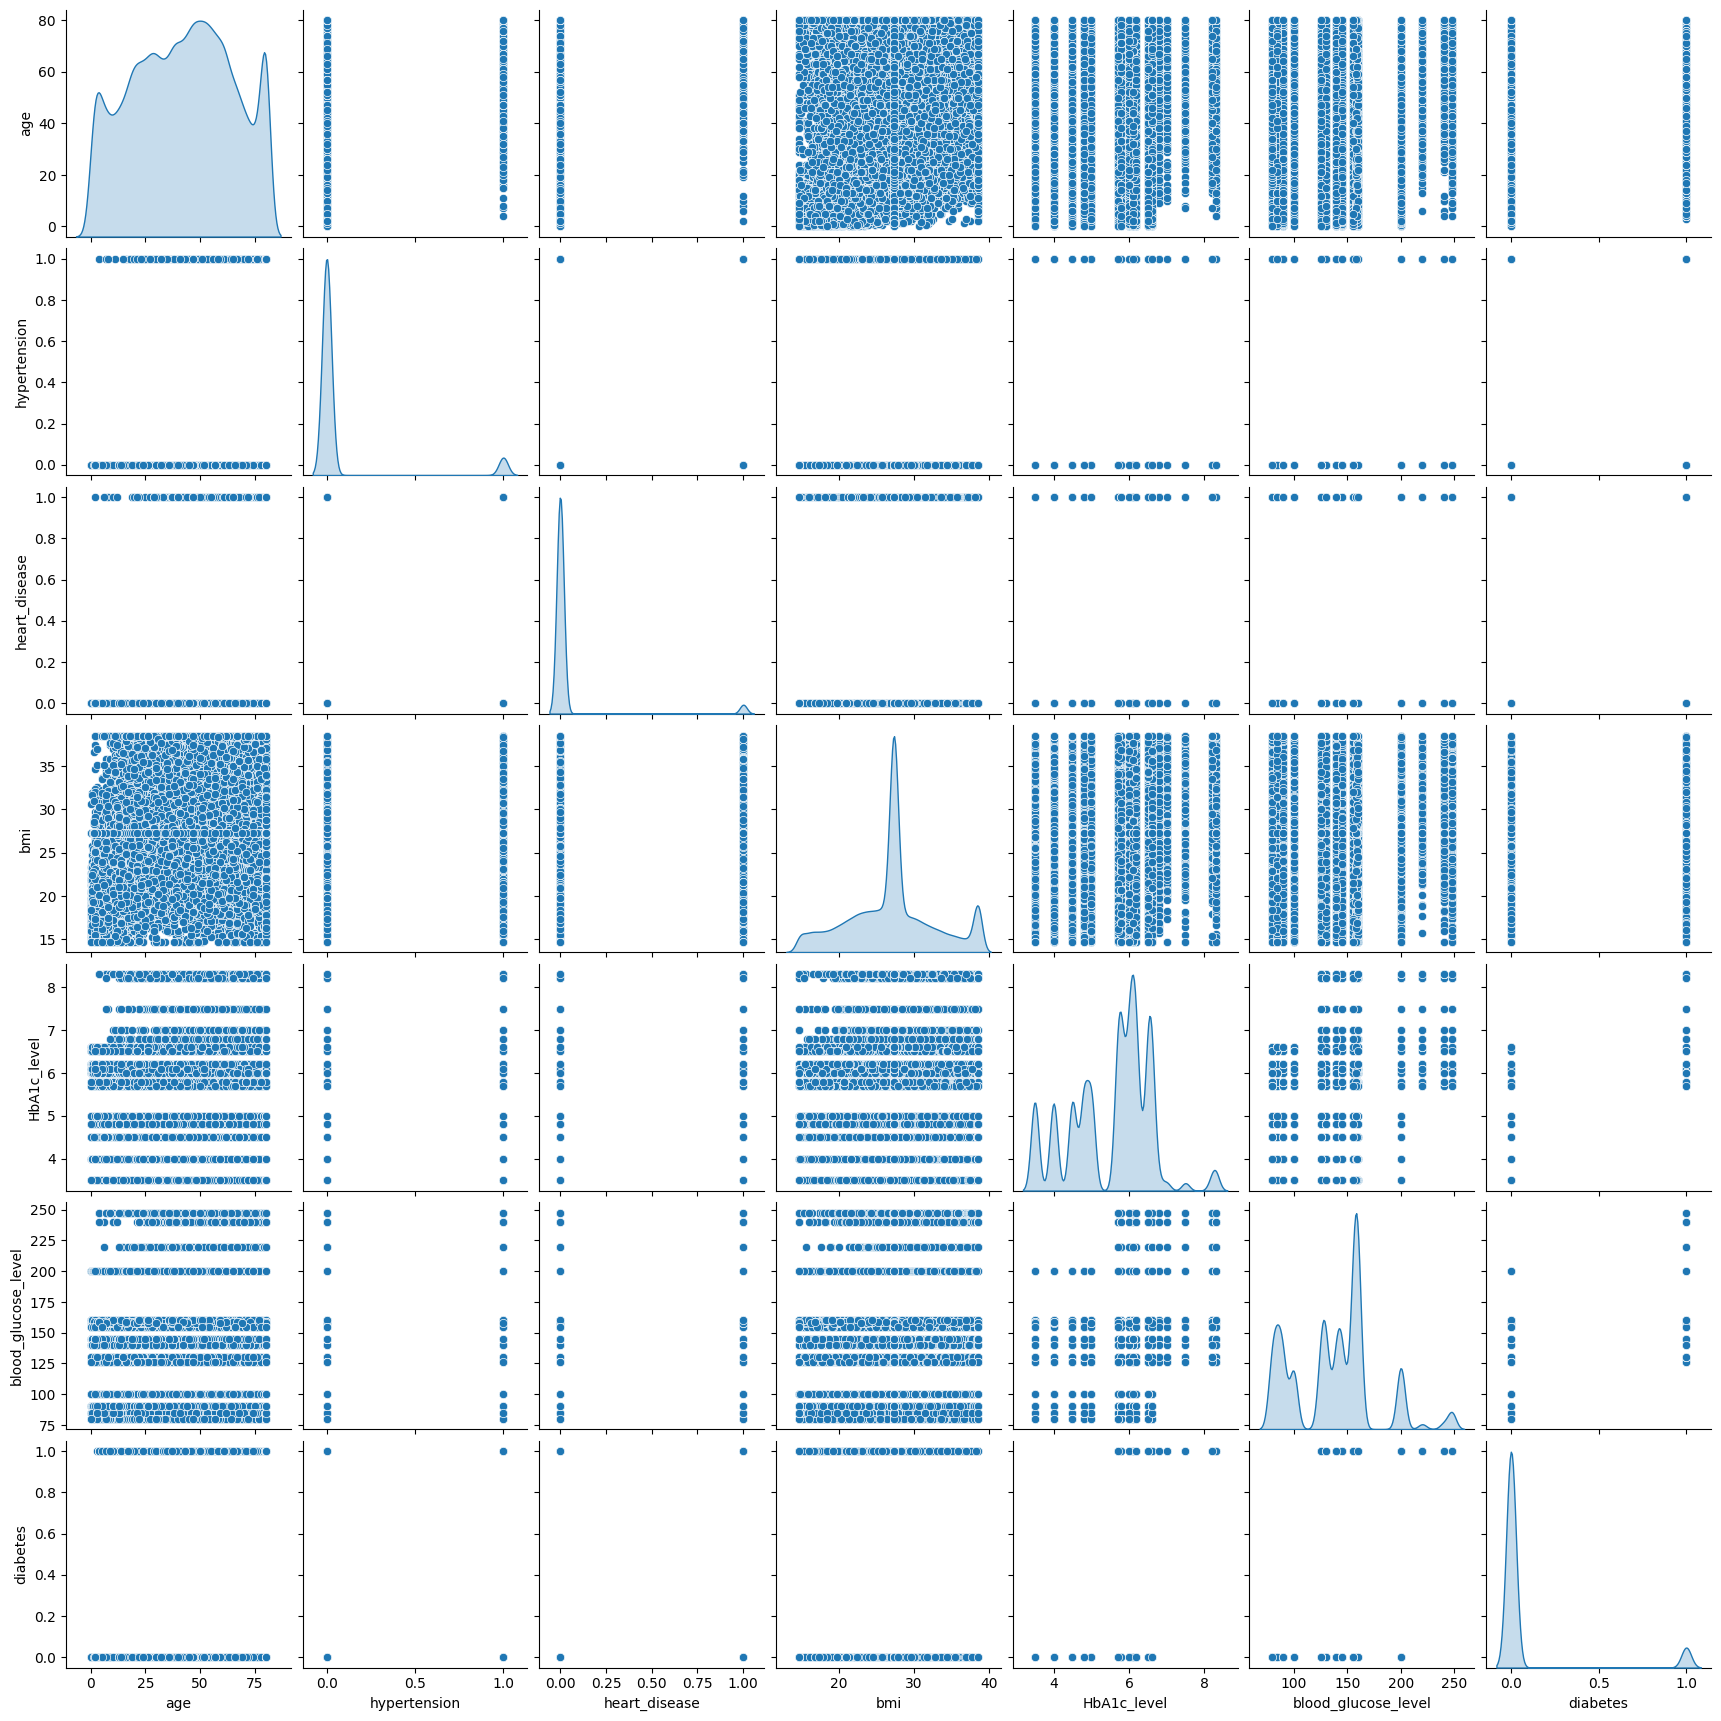

In [14]:
sns.pairplot(df, diag_kind = 'kde')

Visualisasi correlation matrix untuk melihat korelasi atau hubungan fitur-fitur yang ada terhadap target atau label (diabetes).

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

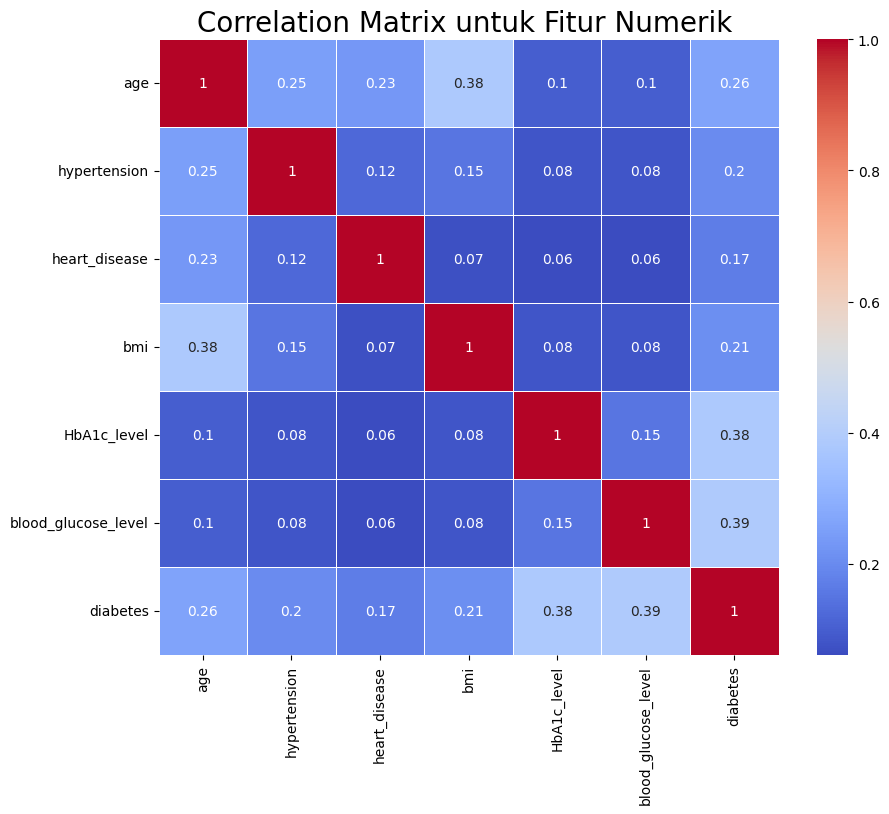

In [15]:
numerical_features = df.select_dtypes(include=['number']).columns

plt.figure(figsize=(10, 8))
correlation_matrix = df[numerical_features].corr().round(2)
 
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

## **4. Data Preparation**

### 4.1. Encoding Fitur Kategori

Mengencoding fitur kategori (gender dan smoking_history) ke fitur numerik menggunakan OneHotEncoder.

In [ ]:
categorical_features = ['gender', 'smoking_history']
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

encoded_array = encoder.fit_transform(df[categorical_features])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_features), index=df.index)

df = df.drop(columns=categorical_features)
df = pd.concat([df, encoded_df], axis=1)

Mengecek hasil dari OneHotEncoder yang membuat fitur baru dari hasil encoding.

In [17]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140.0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,54.0,0,0,27.32,6.6,80.0,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,28.0,0,0,27.32,5.7,158.0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,36.0,0,0,23.45,5.0,155.0,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,76.0,1,1,20.14,4.8,155.0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


### 4.2. Standarisasi Fitur

Melakukan standarisasi atau normalisasi fitur numerik yang rentangnya beragam seperti kolom 'age', 'bmi', 'blood_glucose_level' dan 'HbA1c_level' menggunakan StandardScaler untuk menyamakan rentang nilai.

In [18]:
numerical_features = ['age', 'bmi', 'blood_glucose_level', 'HbA1c_level']
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

Melihat hasil perubahan dari nilai pada fitur numerik yang ditentukan sebelumnya.

In [19]:
df.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,1.692704,0,1,-0.317679,1.031178,0.067835,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.538006,0,0,0.057889,1.031178,-1.490353,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.616691,0,0,0.057889,0.172162,0.535292,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.261399,0,0,-0.624482,-0.495962,0.457382,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.515058,1,1,-1.208112,-0.686854,0.457382,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


### 4.3. Train-Test-Split

Membagi data menjadi train dan test, 70% train atau 70000 sampel dan 30% atau 30000 untuk test.

In [20]:
X = df.drop(columns=["diabetes"])  
y = df["diabetes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (70000, 14)
y_train shape: (70000,)
X_test shape: (30000, 14)
y_test shape: (30000,)


## **5. Model Development**

### 5.1. Random Forest

Load model Random Forest dan melatihnya dengan data train.

In [21]:
model_randomforest = RandomForestClassifier(n_estimators=100, random_state=123)
model_randomforest.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

### 5.2. XGBoost

Load model XGBoost dan melatihnya dengan data train.

In [22]:
model_xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=123)
model_xgboost.fit(X_train, y_train)

/mnt/d/Artificial Intellegence/Machine Learning/CodingCamp/Proyek Machine Learning Terapan/PredictiveAnalysis/env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [06:37:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

### 5.3 LightGBM

Load model LightGBM dan melatihnya dengan data train.

In [23]:
model_lightgbm = LGBMClassifier(random_state=123)
model_lightgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 5938, number of negative: 64062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 413
[LightGBM] [Info] Number of data points in the train set: 70000, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.084829 -> initscore=-2.378479
[LightGBM] [Info] Start training from score -2.378479


LGBMClassifier(random_state=123)

## **6. Evaluasi Model**

### 6.1. Random Forest

Evaluasi metrik accuracy_score dan classification_report (precision, recall dan f1-score) pada model Random Forest.


Model: Random Forest
Test Accuracy: 0.9683

--- Classification Report Random Forest ---
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     27438
           1       0.93      0.68      0.79      2562

    accuracy                           0.97     30000
   macro avg       0.95      0.84      0.88     30000
weighted avg       0.97      0.97      0.97     30000

Confusion Matrix Random Forest
[[27310   128]
 [  822  1740]]


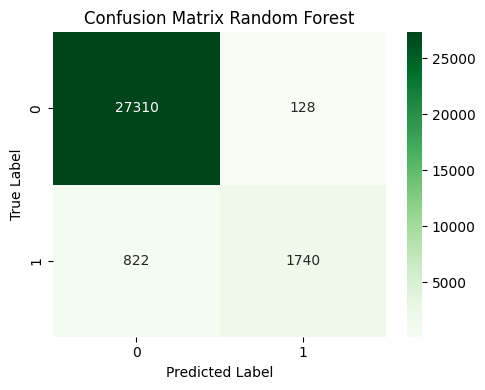

In [42]:
y_test_pred = model_randomforest.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nModel: Random Forest")
print(f"Test Accuracy: {test_acc:.4f}")

print("\n--- Classification Report Random Forest ---\n", classification_report(y_test, y_test_pred))

test_cm = confusion_matrix(y_test, y_test_pred)

print('Confusion Matrix Random Forest')
print(test_cm)

fig, axes = plt.subplots(1, figsize=(5, 4))

sns.heatmap(test_cm, annot=True, fmt='d', cmap='Greens', ax=axes)
axes.set_title("Confusion Matrix Random Forest")
axes.set_xlabel("Predicted Label")
axes.set_ylabel("True Label")

plt.tight_layout()
plt.show()

### 6.2. XGBoost

Evaluasi metrik accuracy_score dan classification_report (precision, recall dan f1-score) pada model XGBoost.


Model: XGBoost
Test Accuracy: 0.9701

--- Classification Report XGBoost ---
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     27438
           1       0.96      0.68      0.80      2562

    accuracy                           0.97     30000
   macro avg       0.96      0.84      0.89     30000
weighted avg       0.97      0.97      0.97     30000

Confusion Matrix XGBoost
[[27357    81]
 [  815  1747]]


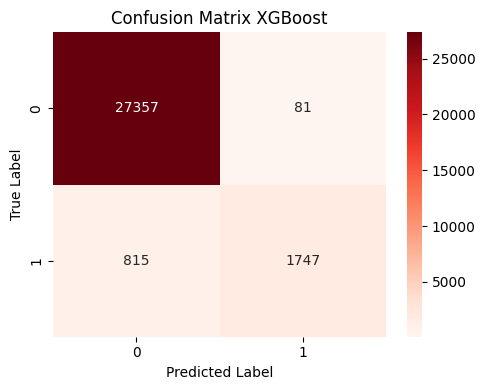

In [43]:
y_test_pred = model_xgboost.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nModel: XGBoost")
print(f"Test Accuracy: {test_acc:.4f}")

print("\n--- Classification Report XGBoost ---\n", classification_report(y_test, y_test_pred))

test_cm = confusion_matrix(y_test, y_test_pred)

print('Confusion Matrix XGBoost')
print(test_cm)

fig, axes = plt.subplots(1, figsize=(5, 4))

sns.heatmap(test_cm, annot=True, fmt='d', cmap='Reds', ax=axes)
axes.set_title("Confusion Matrix XGBoost")
axes.set_xlabel("Predicted Label")
axes.set_ylabel("True Label")

plt.tight_layout()
plt.show()

### 6.3. LightGBM

Evaluasi metrik accuracy_score dan classification_report (precision, recall dan f1-score) pada model LightGBM.


Model: LightGBM
Test Accuracy: 0.9705

--- Classification Report LightGBM ---
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     27438
           1       0.97      0.67      0.80      2562

    accuracy                           0.97     30000
   macro avg       0.97      0.84      0.89     30000
weighted avg       0.97      0.97      0.97     30000

Confusion Matrix LightGBM
[[27389    49]
 [  835  1727]]


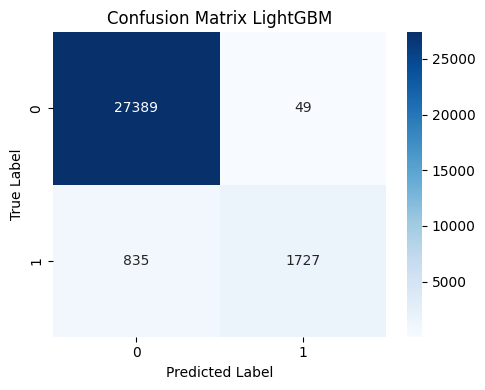

In [45]:
y_test_pred = model_lightgbm.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nModel: LightGBM")
print(f"Test Accuracy: {test_acc:.4f}")

print("\n--- Classification Report LightGBM ---\n", classification_report(y_test, y_test_pred))

test_cm = confusion_matrix(y_test, y_test_pred)

print('Confusion Matrix LightGBM')
print(test_cm)

fig, axes = plt.subplots(1, figsize=(5, 4))

sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=axes)
axes.set_title("Confusion Matrix LightGBM")
axes.set_xlabel("Predicted Label")
axes.set_ylabel("True Label")

plt.tight_layout()
plt.show()